**Reference**: [Niels Rogge's article](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb)

In [10]:
%load_ext autoreload
%autoreload 2

In [16]:
import os
from os.path import join

import numpy as np
import PIL

import shared_utils as su

### Load dataset

In [3]:
from datasets import load_dataset

dataset = load_dataset("nielsr/breast-cancer", split="train")

Using custom data configuration nielsr--breast-cancer-3e5dcd10d1c8eaa0
Found cached dataset parquet (/home/pbagad/.cache/huggingface/datasets/nielsr___parquet/nielsr--breast-cancer-3e5dcd10d1c8eaa0/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [4]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 130
})

In [20]:
def alpha_mask_to_pil_image(amask, threshold=0.5):
    amask = amask.copy()
    amask[amask < threshold] = 0.
    amask_pil = PIL.Image.fromarray(np.clip(amask * 255., 0, 255).astype(np.uint8))
    return amask_pil

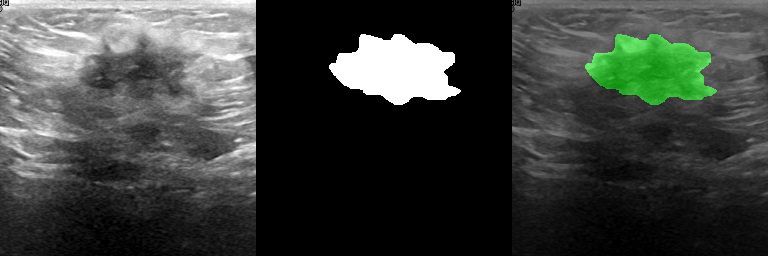

In [22]:
example = dataset[0]
image = example["image"]
label = np.asarray(example["label"])
label_pil = alpha_mask_to_pil_image(label, threshold=0.5)
image_with_label = su.viz.add_mask_on_image(image, label_pil)

su.viz.concat_images([image, label_pil, image_with_label])

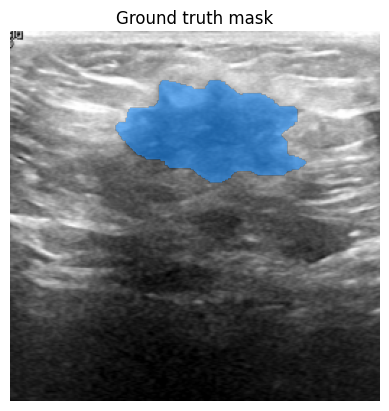

In [24]:
import matplotlib.pyplot as plt
import numpy as np 

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off");

In [26]:
def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [27]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["label"])

        # get bounding box prompt
        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k:v.squeeze(0) for k,v in inputs.items()}

        # add ground truth segmentation
        inputs["ground_truth_mask"] = ground_truth_mask

        return inputs

In [28]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

ImportError: cannot import name 'SamProcessor' from 'transformers' (/home/pbagad/install/miniconda3/envs/atp/lib/python3.7/site-packages/transformers/__init__.py)